In [1]:
# load package
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import lightgbm as lgb


# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/InClass Prediction Competition/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')
#你可以选择修改 ast_note_iteractively kernel 选项来使得 Jupyter 为每一行的变量或语句执行这个操作，以便你可以立即看到多条语句一起输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train= pd.read_csv('train.csv',encoding='big5')
y = train['Class']

In [3]:
from collections import Counter
print(sorted(Counter(y).items()))

[(0, 199030), (1, 334)]


### Start undersampling by NearMiss

In [4]:
from imblearn.under_sampling import (TomekLinks, NeighbourhoodCleaningRule, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, NearMiss)
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority', random_state=0, n_neighbors=3) 
enn = EditedNearestNeighbours(sampling_strategy='majority', random_state=0, n_neighbors=3)
renn = RepeatedEditedNearestNeighbours(sampling_strategy='majority', random_state=0, n_neighbors=3,kind_sel='mode')#[(0, 199004), (1, 334)]
nm1 = NearMiss(sampling_strategy='majority', random_state=0, n_neighbors=3, version=1,ratio=0.0016034, return_indices=True)
# ratio=0.0016034 from 137/85443

In [5]:
for_under_x = train.drop(['TXKEY','Time','Class'], axis=1)
for_under_y = train['Class']

In [6]:
%%time
result_nm1 = nm1.fit_sample(for_under_x, for_under_y)
result_nm1_indices = result_nm1[2]
print(type(result_nm1_indices))
del (for_under_x,for_under_y,result_nm1)

<class 'numpy.ndarray'>
CPU times: user 1.41 s, sys: 88.2 ms, total: 1.5 s
Wall time: 1.5 s


In [7]:
train_under = train.iloc[result_nm1_indices]
for_tomek_x = train_under.drop(['TXKEY','Time','Class'], axis=1)
for_tomek_y = train_under['Class']

### Start undersampling by Tomek’s links

In [8]:
%%time
result_tomek = TomekLinks(sampling_strategy='all',return_indices=True).fit_sample(for_tomek_x, for_tomek_y)
result_tomek_indices = result_tomek[2]

CPU times: user 1min 23s, sys: 540 ms, total: 1min 23s
Wall time: 1min 24s


In [9]:
train_tomek = train_under.iloc[result_tomek_indices]

In [10]:
test= pd.read_csv('test_public.csv',encoding='big5')
# append in ONE data
test = test.dropna()
data=train_tomek.append(test, ignore_index=True)

In [11]:
data['s_in_a_Day']= data['Time']%(60*60*24)
import math
data['h_in_a_Day']= data['s_in_a_Day'].map(lambda x: math.floor(x/(60*60)))

In [12]:
data.head()

,Amount,Class,TXKEY,Time,V1,V10,V11,V12,V13,V14,...,V28,V3,V4,V5,V6,V7,V8,V9,s_in_a_Day,h_in_a_Day
0,0.76,0.0,T73066,54959.0,1.176665,-0.583755,2.270190,0.617925,-0.379276,-1.029994,...,0.031025,-0.492232,0.757094,0.243043,-0.783510,0.224076,-0.036926,-0.421679,54959.0,15
1,0.76,0.0,T39230,39753.0,1.176665,-0.583755,2.270190,0.617925,-0.379276,-1.029994,...,0.031025,-0.492232,0.757094,0.243043,-0.783510,0.224076,-0.036926,-0.421679,39753.0,11
2,0.76,0.0,T68944,53200.0,1.176564,-0.579708,2.246691,0.544641,-0.517070,-1.002571,...,0.030729,-0.495097,0.758433,0.230745,-0.786788,0.214727,-0.029098,-0.400815,53200.0,14
3,0.76,0.0,T22976,32528.0,1.191085,-0.580188,2.067054,0.490841,-0.454383,-1.020222,...,0.028698,-0.580802,0.709803,0.333490,-0.668293,0.212136,-0.017419,-0.390733,32528.0,9
4,0.76,0.0,T25425,33603.0,1.191135,-0.582212,2.078804,0.527483,-0.385487,-1.033933,...,0.028846,-0.579370,0.709133,0.339638,-0.666654,0.216810,-0.021333,-0.401165,33603.0,9


In [13]:
# 運用'Class'欄位來判斷訓練集還是測試集
dataTrain = data[pd.notnull(data['Class'])].sort_values(by=["Time"])
dataTest = data[~pd.notnull(data['Class'])].sort_values(by=["Time"])
dataTrain.columns

Index(['Amount', 'Class', 'TXKEY', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13',
       'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6', 'V7',
       'V8', 'V9', 's_in_a_Day', 'h_in_a_Day'],
      dtype='object')

In [14]:
dataTrain = dataTrain.drop(['s_in_a_Day'], axis=1)#,'s_in_a_Day', 'h_in_a_Day'
dataTest = dataTest.drop(['TXKEY','Class','s_in_a_Day'], axis=1)
X_feature = dataTrain.drop(['TXKEY','Class'], axis=1)
y_t =dataTrain['Class']

In [15]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.33, random_state=2884)

In [16]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [17]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators = 150, random_state=0) #, objective = 'binary'


param_grid = {
    'objective':['binary'],
    'learning_rate': [0.04,0.05], 
    'num_leaves': [128],
    'feature_fraction': [0.7],
    'bagging_fraction': [0.95],
    'max_depth':[7],
    #'max_bin': [6],
    'bagging_freq':[5],
    'lambda_l1': [0.1] , #[44,133] then 44 [44,88] then 44 np.arange(38,44,1) np.arange(16,20,1)
    'lambda_l2': [0.02,0.04] ,#np.arange(11,15,1) then 13
    #'reg_alpha':[4,10] ,
    #'min_split_gain': [0.04], 
    'min_child_weight': [2] 
}

LGBM_grid = GridSearchCV(estimator, param_grid,scoring='recall',cv=4)#,cv=4
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators = 150, random_state=0 ,
                                     objective = LGBM_grid.best_params_['objective'],
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                             bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              #max_bin = LGBM_grid.best_params_['max_bin'],
                                bagging_freq = LGBM_grid.best_params_['bagging_freq'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                              #reg_alpha = LGBM_grid.best_params_['reg_alpha'],
                            #min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight']
                                    )
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print("Predicting is over")

Start training...


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=150,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'objective': ['binary'], 'learning_rate': [0.04, 0.05], 'num_leaves': [128], 'feature_fraction': [0.7], 'bagging_fraction': [0.95], 'max_depth': [7], 'bagging_freq': [5], 'lambda_l1': [0.1], 'lambda_l2': [0.02, 0.04], 'min_child_weight': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

Best parameters found by grid search are: {'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.7, 'lambda_l1': 0.1, 'lambda_l2': 0.04, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 2, 'num_leaves': 128, 'objective': 'binary'}
Start predicting...
Predicting is over


Accuracy:1.000
Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     65666
         1.0       0.93      0.85      0.89       112

   micro avg       1.00      1.00      1.00     65778
   macro avg       0.97      0.92      0.94     65778
weighted avg       1.00      1.00      1.00     65778

Confusion matrix
[[65659     7]
 [   17    95]]
ROC AUC Score
0.9859309666668117
Feature importances: [149, 43, 38, 108, 80, 86, 61, 145, 74, 99, 76, 43, 79, 49, 59, 68, 46, 50, 49, 45, 108, 58, 58, 82, 154, 47, 36, 77, 85, 63, 47]
Plot feature importances...


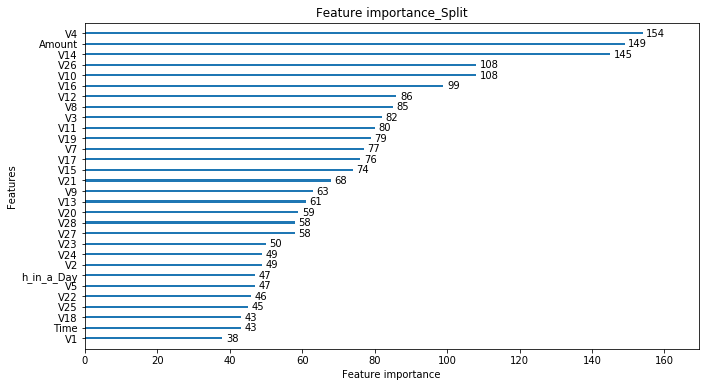

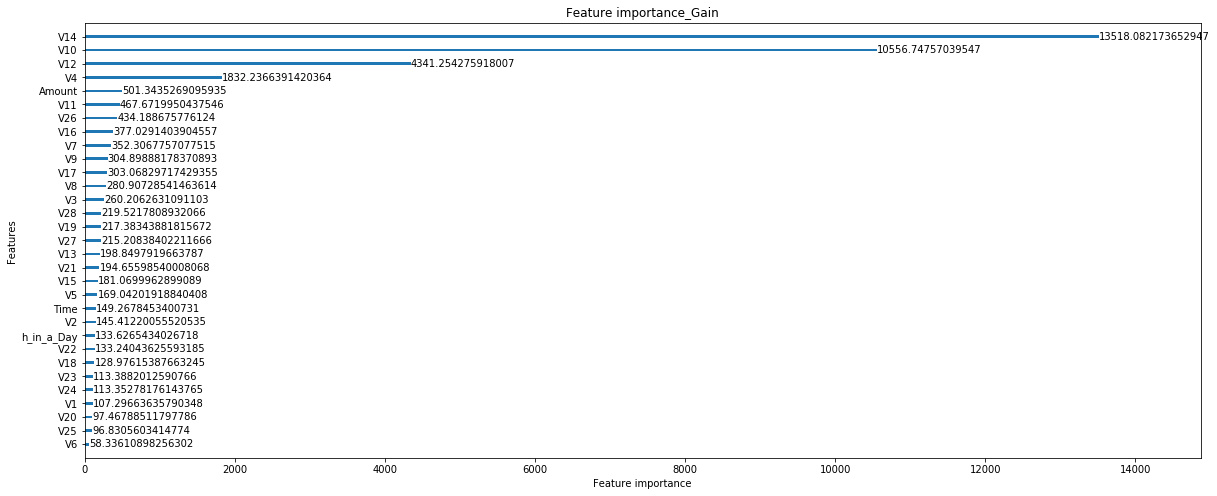

In [18]:
#對test算performance
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
split_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, ignore_zero=False,figsize=(11, 6),grid=False, title='Feature importance_Split')
gain_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=40, importance_type='gain',figsize=(20, 8),grid=False, title='Feature importance_Gain')


In [19]:
#拿全部的dataTrain來建
LGBM_grid_final_fit_all = LGBM_grid_final.fit(X_feature, y_t)

In [20]:
LGBM_grid_final_fit_res =LGBM_grid_final_fit_all.predict_proba(dataTest)

In [21]:
df_p = pd.DataFrame({'p0':LGBM_grid_final_fit_res[:,0],'p1':LGBM_grid_final_fit_res[:,1]})

In [22]:
submit = pd.read_csv('sampleSubmission.csv',encoding='big5')
out = pd.concat([submit, df_p], axis=1, ignore_index=True)
out.sort_values(by=[3], ascending=False, inplace=True)
out.rename(columns={0:'TXKEY', 1:'Class', 2:'p0', 3:'p1'},inplace=True)
print('偽冒機率門檻：',out.iloc[137,3])
out.Class[out.p1>=out.iloc[137,3]]=1

偽冒機率門檻： 0.5616070578638178


In [23]:
out=out[['TXKEY','Class']]
out.to_csv("submit.csv", index= False)

In [24]:
from matplotlib import pyplot as plt
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()